In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from IPython.display import clear_output
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn.metrics import mean_absolute_error,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn import svm  
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer

test_file_path = '../input/titanic/test.csv'
train_file_path = '../input/titanic/train.csv'
gender_data_path = '../input/titanic/gender_submission.csv'

test_data = pd.read_csv(test_file_path)
train_data = pd.read_csv(train_file_path)
gender_data = pd.read_csv(gender_data_path)

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#AGE
data = [train_data, test_data]
for dataset in data:
    mean = train_data["Age"].mean()
    std = test_data["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_data["Age"].astype(int)

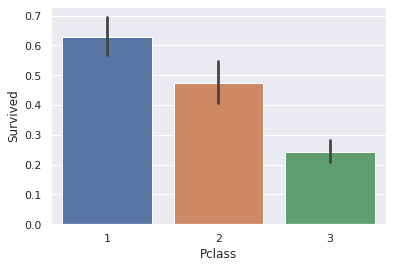

In [3]:
sns.barplot(x='Pclass', y='Survived', data=train_data);

In [4]:
embarked_mode = train_data['Embarked'].mode()
data = [train_data, test_data]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(embarked_mode)

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


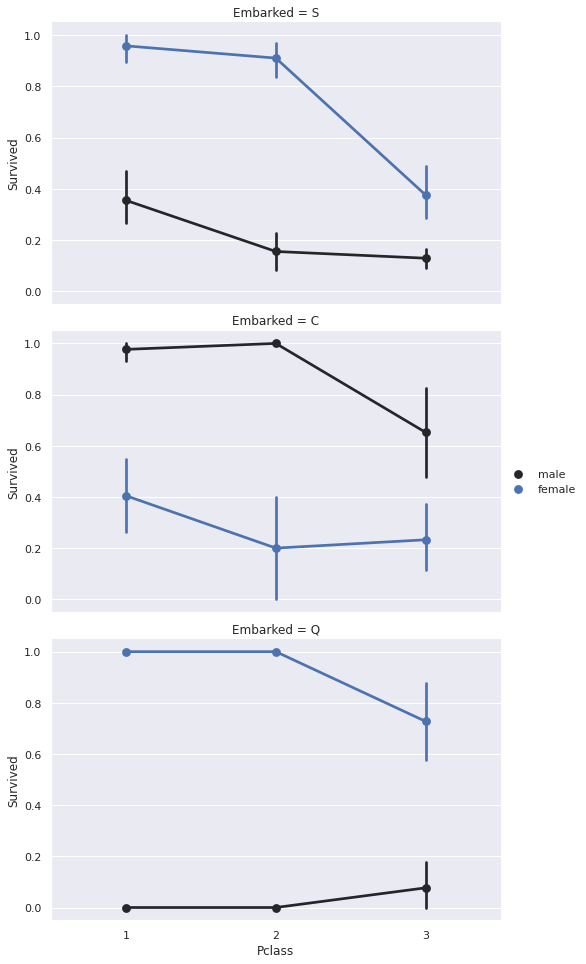

In [5]:
FacetGrid = sns.FacetGrid(train_data, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None )
FacetGrid.add_legend();

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


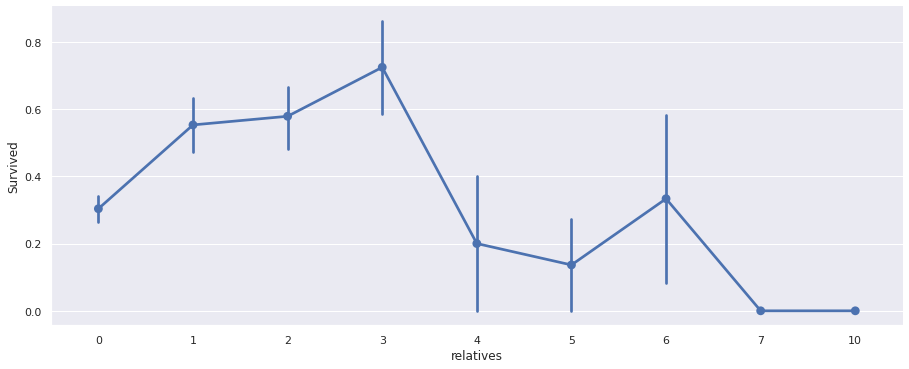

In [6]:
data = [train_data, test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'travelled_alone'] = 'No'
    dataset.loc[dataset['relatives'] == 0, 'travelled_alone'] = 'Yes'
axes = sns.factorplot('relatives','Survived', 
                      data=train_data, aspect = 2.5, );

In [7]:
param_test1 = {
    'n_estimators': [100,200,500,750,1000],
    'max_depth': [3,5,7,9],
    'min_child_weight': [1,3,5],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.1, 1],
    'learning_rate': [0.01, 0.02, 0.05, 0.1]
}

In [8]:
# from sklearn import preprocessing
# train_numerical_features = list(train_data.select_dtypes(include=['int64', 'float64', 'int32']).columns)
# ss_scaler = StandardScaler()
# train_data_ss = pd.DataFrame(data = train_data)
# train_data[train_numerical_features] = ss_scaler.fit_transform(train_data_ss[train_numerical_features]).astype('float64')

# lab_enc = preprocessing.LabelEncoder()
# train_data = lab_enc.fit_transform(train_data)

In [9]:
# test_numerical_features = list(test_data.select_dtypes(include=['int64', 'float64', 'int32']).columns)
# ss_scaler = StandardScaler()
# test_data_ss = pd.DataFrame(data = test_data)
# test_data[test_numerical_features] = ss_scaler.fit_transform(test_data_ss[test_numerical_features]).astype('float64')

# lab_enc = preprocessing.LabelEncoder()
# training_scores_encoded = lab_enc.fit_transform(training_scores_Y)

In [10]:
def defsex(passenger):
    age,sex = passenger
    if age < 16:
        return 2
    if sex == 'male':
        return 0
    else:
        return 1

In [11]:
def defemb(passenger):
    embark = passenger
    if embark == "S":
        return 0
    if embark == "C":
        return 1
    if embark == "Q":
        return 2

In [12]:
def deftrav(passenger):
    trav = passenger
    if trav == "yes":
        return 1
    if trav == "no":
        return 0

In [13]:
#Binarize sex
train_data['Sex'] = train_data[['Age','Sex']].apply(defsex,axis=1)
test_data['Sex']  = test_data[['Age','Sex']].apply(defsex,axis=1)

train_data['Embarked'] = train_data['Embarked'].apply(defemb)
test_data['Embarked'] = test_data['Embarked'].apply(defemb)

train_data['travelled_alone'] = train_data['travelled_alone'].apply(deftrav)
test_data['travelled_alone'] = test_data['travelled_alone'].apply(deftrav)

In [14]:
train_data.isnull().sum()

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             2
relatives            0
travelled_alone    891
dtype: int64

In [15]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = {0: 10000, 1: 10000})
X_test_os,y_test_os = sm.fit_resample(train_data.drop(['Survived',"Name",'Ticket',"Cabin","Embarked","travelled_alone"],axis=1),train_data['Survived'])

/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (10000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 549)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (10000) in class 1 will be larger than the number of samples in the majority class (class #0 -> 549)
  f"After over-sampling, the number of samples ({n_samples})"


In [16]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'relatives',
       'travelled_alone'],
      dtype='object')

In [17]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'relatives',
       'travelled_alone'],
      dtype='object')

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

#data["Age"] = data["Age"].astype(int)
#if ["Age"]

#y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp",'Parch',"Age","Fare", "Embarked","relatives","travelled_alone"]
#X = pd.get_dummies(train_data[features])
#X_test = pd.get_dummies(test_data[features])


X_train, X_valid, y_train, y_valid = train_test_split(X_test_os,y_test_os,train_size=0.7, test_size=0.3,random_state=42)

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
model.fit(X_train, y_train)
#predictions = model.predict(X_test)

preds = model.predict(X_valid)

print(classification_report(y_valid, preds))
print(confusion_matrix(y_valid, preds))

#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('submission.csv', index=False)

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      3034
           1       0.83      0.75      0.79      2966

    accuracy                           0.80      6000
   macro avg       0.80      0.80      0.80      6000
weighted avg       0.80      0.80      0.80      6000

[[2566  468]
 [ 736 2230]]


In [19]:
param_test1 = {
    'n_estimators': range(10,200,20),
    'max_depth': [3,5,7,9],
    'criterion' : ['gini', 'entropy']
}

In [20]:
from sklearn.model_selection import GridSearchCV


knn = RandomForestClassifier()
knn_random = GridSearchCV(estimator = knn, param_grid = param_test1,verbose = 2)
knn_random.fit(X_train, y_train)

print("End")


preds = knn_random.predict(X_valid)

print(classification_report(y_valid, preds))
print(confusion_matrix(y_valid, preds))



Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END .......criterion=gini, max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......criterion=gini, max_depth=3, n_estimators=10; total time=   0.2s
[CV] END .......criterion=gini, max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......criterion=gini, max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......criterion=gini, max_depth=3, n_estimators=10; total time=   0.1s
[CV] END .......criterion=gini, max_depth=3, n_estimators=30; total time=   0.1s
[CV] END .......criterion=gini, max_depth=3, n_estimators=30; total time=   0.2s
[CV] END .......criterion=gini, max_depth=3, n_estimators=30; total time=   0.2s
[CV] END .......criterion=gini, max_depth=3, n_estimators=30; total time=   0.2s
[CV] END .......criterion=gini, max_depth=3, n_estimators=30; total time=   0.1s
[CV] END .......criterion=gini, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END .......criterion=gini, max_depth=3, n_

In [21]:
knn_random.get_params() 

{'cv': None,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'n_jobs': None,
 'param_grid': {'n_estimators': range(10, 200, 20),
  'max_depth': [3, 5, 7, 9],
  'criterion': ['gini', 'entropy']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 2}

In [22]:
topred = test_data.drop(['Name'],axis=1)
topred = topred.drop(['Ticket'],axis=1)
topred = topred.drop(['Cabin'],axis=1)
topred = topred.drop(['Embarked'],axis=1)
topred = topred.drop(['travelled_alone'],axis=1)

In [23]:
topred['Fare'].fillna(topred['Fare'].median(), inplace=True)

In [24]:


final_pred = knn_random.predict(topred)

print(classification_report(y_valid, preds))
print(confusion_matrix(y_valid, preds))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3034
           1       0.91      0.81      0.86      2966

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000

[[2810  224]
 [ 576 2390]]


In [25]:
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": final_pred
    })
submission.to_csv('titanic.csv', index=False)